<a href="https://colab.research.google.com/github/sa21262/datascience22/blob/main/lab3task/bank_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [226]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


import itertools

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn import metrics
from sklearn import datasets
import sklearn

In [227]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/ce888/master/lab3/bank-additional-full.csv", delimiter=";")
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [229]:
group_onehotencoding = ["marital","default","housing","loan","contact","campaign","previous","poutcome"]
group_ordencoding = ["job","education", "month", "day_of_week", "y"]
group_standardscalar= ["pdays","nr.employed"]


In [230]:
# Deleting duration column as it said 
df.drop('duration', axis = 1, inplace =True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [231]:
# LabelEncoder is applied here, so levels are numbered now 
label_enc = LabelEncoder()
df['y'] = label_enc.fit_transform(df['y']) # label y is transformed into numbers 

df['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [232]:
df = pd.get_dummies(df) #onehot encoding is performed 
df

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41184,46,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41185,56,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41186,44,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0


In [233]:
print("Number of rows before dropping NaNs: %d" % len(df)) #there are no NaN values in the data 
df = df.dropna()
print("Number of rows after dropping NaNs: %d" % len(df))

Number of rows before dropping NaNs: 41188
Number of rows after dropping NaNs: 41188


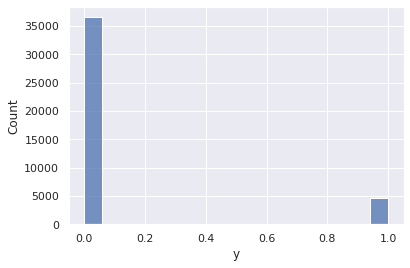

In [234]:
_ = sns.histplot(df['y'], kde=False)

In [235]:
print ('Number of ones as a percentage of lenght of y:')

a=len(df[df['y']==1])

b=len(df['y'])

print ('percentage =', ((a/b)*100))

Number of ones as a percentage of lenght of y:
percentage = 11.265417111780131


In [236]:
# Create separate training and test sets. we'll use the training set for steps 3--6
train_set, test_set = train_test_split(df, test_size=0.2, random_state=50)  
# by setting a random_state above, we make sure anytime we run this line we end up with the same train and test sets
print(len(train_set), len(test_set))

32950 8238


In [237]:
df = train_set.copy()


y_df = df['y'].copy() # y column is seperated 

df.drop('y', axis = 1, inplace =True) # Training set without y 

dummy_clf = DummyClassifier(strategy='most_frequent') # Dummy Classifier Applied  
dummy_clf.fit(df, y_df)
print("Dummy Precision: %.2f" % metrics.average_precision_score(y_df, dummy_clf.predict(df)))


clf=RandomForestClassifier(n_estimators=100,max_depth=3)# random forest classifier applied 
#print(sorted(sklearn.metrics.SCORERS.keys()))
scores = cross_val_score(clf, df , y_df.ravel() , cv=10, scoring=make_scorer(metrics.average_precision_score))  # cross-validation
print("Precision: %.2f +/- %.2f" % (scores.mean(), scores.std()))

clf.fit(df, y_df)
#list(df.columns) # to list the name sof column of a dataset 

Dummy Precision: 0.11
Precision: 0.21 +/- 0.01


RandomForestClassifier(max_depth=3)

In [238]:
# Let's see the feature importances for our classifier
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print(indices)



# Let's get the attibute names:
feat_names = list(df.columns)



# Print the feature ranking
print("Feature ranking:")
for f in range(df.shape[1]):
    print("%d. %s (%f)" % (f + 1, feat_names[indices[f]],  importances[indices[f]]))
a=0.000391 # marital_single
my_list=[] 
for k in range(df.shape[1]):
   
   if importances[indices[k]] < a :
         
       my_list.append(feat_names[indices[k]])
       
my_list2=[] 
my_importance=[] 
print ('lenght ', len(my_list))
print("Feature ranking2:")
for l in range((df.shape[1]) -(len(my_list))):
    my_list2.append(feat_names[indices[l]])
    my_importance.append(importances[indices[l]])
    print("%d. %s (%f)" % (l + 1, feat_names[indices[l]],  importances[indices[l]]))

      
df.drop(my_list , axis = 1, inplace =True)
   

# # Plot the feature importances of the forest
# fig = plt.figure()
# plt.title("Feature importances")
# plt.bar(range(df.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
# plt.xticks(range(df.shape[1]), np.array(feat_names)[indices])
# plt.xlim([-1, df.shape[1]])
# plt.ylim([0, None])

# fig.set_size_inches(20, 10)

[ 8  7  2 61  4  6  5  3  0 52 60 49 43 42 53 33 50 14 59 44 46 17 34 10
 23  1 55 45 22 48 31 51 57 41 56 21 20 26  9 27 28 15 47 58 36 13 37 11
 39 30 18 54 38 25 24 16 32 35 12 29 40 19]
Feature ranking:
1. nr.employed (0.137095)
2. euribor3m (0.136549)
3. pdays (0.128476)
4. poutcome_success (0.123450)
5. emp.var.rate (0.110871)
6. cons.conf.idx (0.084965)
7. cons.price.idx (0.075571)
8. previous (0.041410)
9. age (0.024228)
10. month_oct (0.022987)
11. poutcome_nonexistent (0.019107)
12. month_mar (0.018157)
13. contact_telephone (0.015494)
14. contact_cellular (0.014001)
15. month_sep (0.010619)
16. default_no (0.006989)
17. month_may (0.003955)
18. job_retired (0.003560)
19. poutcome_failure (0.003113)
20. month_apr (0.003098)
21. month_dec (0.002562)
22. job_student (0.002506)
23. default_unknown (0.002197)
24. job_blue-collar (0.001109)
25. marital_single (0.001055)
26. campaign (0.000999)
27. day_of_week_mon (0.000844)
28. month_aug (0.000572)
29. marital_married (0.000557)
3

In [261]:
dummy_clf = DummyClassifier(strategy='most_frequent') # Dummy Classifier Applied  
dummy_clf.fit(df, y_df)
print("Dummy Precision: %.2f" % metrics.average_precision_score(y_df, dummy_clf.predict(df)))


clf=RandomForestClassifier(n_estimators=1000 , max_depth=3)# random forest classifier applied 
#print(sorted(sklearn.metrics.SCORERS.keys()))
scores = cross_val_score(clf, df , y_df.ravel() , cv=10, scoring=make_scorer(metrics.average_precision_score))  # cross-validation
print("Precision: %.2f +/- %.2f" % (scores.mean(), scores.std()))

clf.fit(df, y_df)
#list(df.columns) # to list the name sof column of a dataset 



Dummy Precision: 0.11
Precision: 0.22 +/- 0.01


RandomForestClassifier(max_depth=3, n_estimators=1000)

['nr.employed', 'euribor3m', 'pdays', 'poutcome_success', 'emp.var.rate', 'cons.conf.idx', 'cons.price.idx', 'previous', 'age', 'month_oct', 'poutcome_nonexistent', 'month_mar', 'contact_telephone', 'contact_cellular', 'month_sep', 'default_no', 'month_may', 'job_retired', 'poutcome_failure', 'month_apr', 'month_dec', 'job_student', 'default_unknown', 'job_blue-collar', 'marital_single', 'campaign', 'day_of_week_mon', 'month_aug', 'marital_married', 'month_jun', 'education_university.degree']


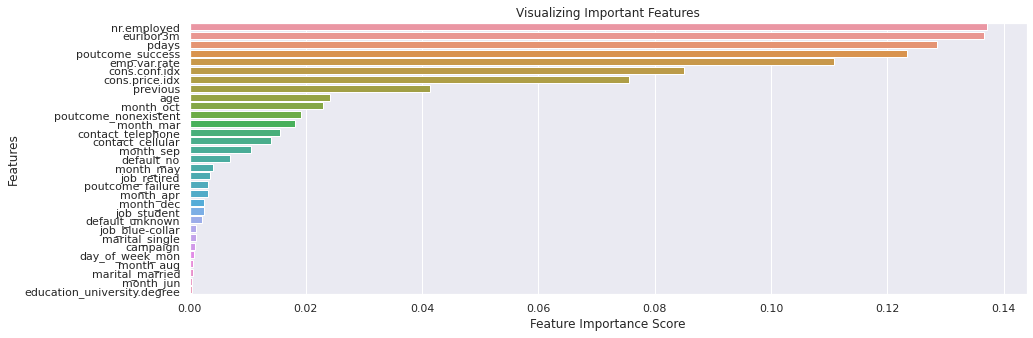

In [241]:
print(my_list2)
feature_imp = pd.Series(my_importance,index=my_list2).sort_values(ascending=False) # another way of finding feature importance 
feature_imp

fig1=sns.barplot(x=feature_imp  , y=feature_imp.index )
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()

sns.set(rc={'figure.figsize':(20,5)})
plt.show()

In [268]:
from sklearn.metrics import average_precision_score
precision=average_precision_score

In [254]:
from sklearn.model_selection import GridSearchCV
parameters = [{'n_estimators':[100, 1000], 'max_depth' : [1,3,5,7]}]



grid_search = GridSearchCV(estimator= clf , param_grid= parameters , scoring= 'precision' , cv= 10, n_jobs= -1)
grid_search = grid_search.fit(df, y_df)

In [255]:
precision = grid_search.best_score_

In [256]:
precision

0.7376511778387036

In [257]:
grid_search.best_params_

{'max_depth': 3, 'n_estimators': 1000}

In [269]:
clf.fit(df, y_df)

RandomForestClassifier(max_depth=3, n_estimators=1000)

In [270]:
df_test = test_set.copy()
y_df_test = df_test['y'].copy()# y is seperated 
df_test.drop('y', axis = 1, inplace =True) # test without y 
df_test.drop(my_list, axis = 1, inplace =True) # test set without irrelevent features  basically its my x_test 

In [271]:
y_pred=clf.predict(df_test)

In [273]:
print("precision:",metrics.average_precision_score(y_df_test, y_pred))

precision: 0.2101532587154249


In [274]:
from sklearn.metrics import average_precision_score
precision=average_precision_score(y_df_test,y_pred)

In [275]:
precision


0.2101532587154249